### Enviroment preparation

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
import pyspark.sql.functions as F 
import numpy as np
import pandas as pd
import random
import time as t
import os
import re
import gc
from subprocess import Popen
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
ControlSparkCluster('stop')

cluster stopped


In [2]:
def ControlSparkCluster(action):
    if action == 'start':
        Popen('./start_cluster.sh',shell=True)
        t.sleep(10)
        print 'cluster started'
    elif action == 'stop':
        Popen('./stop_cluster.sh',shell=True)
        sc.stop()
        t.sleep(3)
        print 'cluster stopped'
    else:
        raise Exception('Unsupported command!')

In [3]:
ControlSparkCluster('start')

cluster started


In [ ]:
conf = SparkConf().setMaster("spark://cathome:7077").setAppName("bosh")\
.setAll((['spark.executor.cores','4']
        ,['spark.driver.cores','4']
        ,['spark.driver.memory','4g']
        ,['spark.driver.maxResultSize','4g']
        ,['spark.executor.memory','4g']
        ,['spark.python.worker.memory','4g']
        ,['spark.default.parallelism','4']
       ))

In [ ]:
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

### Data preparation

In [6]:
dir_name = '../../../diploma_data'

In [7]:
tr_num_file_name = 'train_numeric.csv'
tr_date_file_name = 'train_date.csv'
tr_cat_file_name = 'train_categorical.csv'

In [8]:
tr_num_data_file = '{0}/{1}'.format(dir_name,tr_num_file_name)
tr_date_data_file = '{0}/{1}'.format(dir_name,tr_date_file_name)
tr_cat_data_file = '{0}/{1}'.format(dir_name,tr_cat_file_name)

In [9]:
%%time
df_num = sqlContext.read.csv(tr_num_data_file, sep=',', header=True, inferSchema=True)
df_date = sqlContext.read.csv(tr_date_data_file, sep=',', header=True, inferSchema=True)
df_cat = sqlContext.read.csv(tr_cat_data_file, sep=',', header=True, inferSchema=True)

Py4JJavaError: An error occurred while calling o30.csv.
: org.apache.spark.SparkException: Job 0 cancelled 
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:1375)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1622)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1353)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1326)
	at org.apache.spark.rdd.RDD$$anonfun$first$1.apply(RDD.scala:1367)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1366)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.findFirstLine(CSVFileFormat.scala:206)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.inferSchema(CSVFileFormat.scala:60)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$7.apply(DataSource.scala:184)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$7.apply(DataSource.scala:184)
	at scala.Option.orElse(Option.scala:289)
	at org.apache.spark.sql.execution.datasources.DataSource.org$apache$spark$sql$execution$datasources$DataSource$$getOrInferFileFormatSchema(DataSource.scala:183)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:387)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:152)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:415)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


### Data analisys/Data transformation

In [ ]:
num_sample_file = '{0}/{1}'.format(dir_name,'num_sample.orc')
date_sample_file = '{0}/{1}'.format(dir_name,'date_sample.orc')
cat_sample_file = '{0}/{1}'.format(dir_name,'cat_sample.orc')

In [59]:
df_num.sample(False, 0.02, seed=112).write.parquet(num_sample_file)
df_date.sample(False, 0.02, seed=112).write.parquet(date_sample_file)
df_cat.sample(False, 0.02, seed=112).write.parquet(cat_sample_file)

Py4JJavaError: An error occurred while calling o9055.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply$mcV$sp(FileFormatWriter.scala:147)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:101)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:58)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:56)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:74)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.datasources.DataSource.write(DataSource.scala:492)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:215)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:198)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:494)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 35.0 failed 4 times, most recent failure: Lost task 2.3 in stage 35.0 (TID 449, 192.168.1.4, executor 14): java.lang.OutOfMemoryError: Java heap space
	at org.apache.parquet.column.values.dictionary.IntList.initSlab(IntList.java:90)
	at org.apache.parquet.column.values.dictionary.IntList.<init>(IntList.java:86)
	at org.apache.parquet.column.values.dictionary.DictionaryValuesWriter.<init>(DictionaryValuesWriter.java:93)
	at org.apache.parquet.column.values.dictionary.DictionaryValuesWriter$PlainDoubleDictionaryValuesWriter.<init>(DictionaryValuesWriter.java:417)
	at org.apache.parquet.column.ParquetProperties.dictionaryWriter(ParquetProperties.java:139)
	at org.apache.parquet.column.ParquetProperties.dictWriterWithFallBack(ParquetProperties.java:178)
	at org.apache.parquet.column.ParquetProperties.getValuesWriter(ParquetProperties.java:203)
	at org.apache.parquet.column.impl.ColumnWriterV1.<init>(ColumnWriterV1.java:83)
	at org.apache.parquet.column.impl.ColumnWriteStoreV1.newMemColumn(ColumnWriteStoreV1.java:68)
	at org.apache.parquet.column.impl.ColumnWriteStoreV1.getColumnWriter(ColumnWriteStoreV1.java:56)
	at org.apache.parquet.io.MessageColumnIO$MessageColumnIORecordConsumer.<init>(MessageColumnIO.java:184)
	at org.apache.parquet.io.MessageColumnIO.getRecordWriter(MessageColumnIO.java:376)
	at org.apache.parquet.hadoop.InternalParquetRecordWriter.initStore(InternalParquetRecordWriter.java:109)
	at org.apache.parquet.hadoop.InternalParquetRecordWriter.<init>(InternalParquetRecordWriter.java:99)
	at org.apache.parquet.hadoop.ParquetRecordWriter.<init>(ParquetRecordWriter.java:100)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:327)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:283)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:145)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.<init>(FileFormatWriter.scala:234)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:182)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:129)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:128)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply$mcV$sp(FileFormatWriter.scala:127)
	... 31 more
Caused by: java.lang.OutOfMemoryError: Java heap space
	at org.apache.parquet.column.values.dictionary.IntList.initSlab(IntList.java:90)
	at org.apache.parquet.column.values.dictionary.IntList.<init>(IntList.java:86)
	at org.apache.parquet.column.values.dictionary.DictionaryValuesWriter.<init>(DictionaryValuesWriter.java:93)
	at org.apache.parquet.column.values.dictionary.DictionaryValuesWriter$PlainDoubleDictionaryValuesWriter.<init>(DictionaryValuesWriter.java:417)
	at org.apache.parquet.column.ParquetProperties.dictionaryWriter(ParquetProperties.java:139)
	at org.apache.parquet.column.ParquetProperties.dictWriterWithFallBack(ParquetProperties.java:178)
	at org.apache.parquet.column.ParquetProperties.getValuesWriter(ParquetProperties.java:203)
	at org.apache.parquet.column.impl.ColumnWriterV1.<init>(ColumnWriterV1.java:83)
	at org.apache.parquet.column.impl.ColumnWriteStoreV1.newMemColumn(ColumnWriteStoreV1.java:68)
	at org.apache.parquet.column.impl.ColumnWriteStoreV1.getColumnWriter(ColumnWriteStoreV1.java:56)
	at org.apache.parquet.io.MessageColumnIO$MessageColumnIORecordConsumer.<init>(MessageColumnIO.java:184)
	at org.apache.parquet.io.MessageColumnIO.getRecordWriter(MessageColumnIO.java:376)
	at org.apache.parquet.hadoop.InternalParquetRecordWriter.initStore(InternalParquetRecordWriter.java:109)
	at org.apache.parquet.hadoop.InternalParquetRecordWriter.<init>(InternalParquetRecordWriter.java:99)
	at org.apache.parquet.hadoop.ParquetRecordWriter.<init>(ParquetRecordWriter.java:100)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:327)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:283)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:145)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.<init>(FileFormatWriter.scala:234)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:182)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:129)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:128)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [13]:
%%time
#df_num_smpl = sqlContext.read.csv(num_sample_file, sep=',', header=True, inferSchema=True)
df_date_smpl = sqlContext.read.csv(date_sample_file, sep=',', header=True, inferSchema=True)
#df_cat_smpl = sqlContext.read.csv(cat_sample_file, sep=',', header=True, inferSchema=True)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.11 s


In [33]:
l = ['a','b','c']
df = sqlContext.createDataFrame([(1, 4, 3),(2,56,32)], ['a', 'b', 'c'])
df.select(F.greatest(*l).alias("greatest")).collect()

[Row(greatest=4), Row(greatest=56)]

In [37]:
l2 = df_date_smpl.columns[1:]

In [41]:
df_date_smpl.select(F.greatest(*l2).alias("maxdate"))

AnalysisException: u"cannot resolve 'greatest(`L0_S0_D1`, `L0_S0_D3`, `L0_S0_D5`, `L0_S0_D7`, `L0_S0_D9`, `L0_S0_D11`, `L0_S0_D13`, `L0_S0_D15`, `L0_S0_D17`, `L0_S0_D19`, `L0_S0_D21`, `L0_S0_D23`, `L0_S1_D26`, `L0_S1_D30`, `L0_S2_D34`, `L0_S2_D38`, `L0_S2_D42`, `L0_S2_D46`, `L0_S2_D50`, `L0_S2_D54`, `L0_S2_D58`, `L0_S2_D62`, `L0_S2_D66`, `L0_S3_D70`, `L0_S3_D74`, `L0_S3_D78`, `L0_S3_D82`, `L0_S3_D86`, `L0_S3_D90`, `L0_S3_D94`, `L0_S3_D98`, `L0_S3_D102`, `L0_S4_D106`, `L0_S4_D111`, `L0_S5_D115`, `L0_S5_D117`, `L0_S6_D120`, `L0_S6_D124`, `L0_S6_D127`, `L0_S6_D130`, `L0_S6_D134`, `L0_S7_D137`, `L0_S7_D139`, `L0_S7_D140`, `L0_S7_D141`, `L0_S7_D143`, `L0_S8_D145`, `L0_S8_D147`, `L0_S8_D148`, `L0_S8_D150`, `L0_S9_D152`, `L0_S9_D157`, `L0_S9_D162`, `L0_S9_D167`, `L0_S9_D172`, `L0_S9_D177`, `L0_S9_D182`, `L0_S9_D187`, `L0_S9_D192`, `L0_S9_D197`, `L0_S9_D202`, `L0_S9_D207`, `L0_S9_D212`, `L0_S10_D216`, `L0_S10_D221`, `L0_S10_D226`, `L0_S10_D231`, `L0_S10_D236`, `L0_S10_D241`, `L0_S10_D246`, `L0_S10_D251`, `L0_S10_D256`, `L0_S10_D261`, `L0_S10_D266`, `L0_S10_D271`, `L0_S10_D276`, `L0_S11_D280`, `L0_S11_D284`, `L0_S11_D288`, `L0_S11_D292`, `L0_S11_D296`, `L0_S11_D300`, `L0_S11_D304`, `L0_S11_D308`, `L0_S11_D312`, `L0_S11_D316`, `L0_S11_D320`, `L0_S11_D324`, `L0_S11_D328`, `L0_S12_D331`, `L0_S12_D333`, `L0_S12_D335`, `L0_S12_D337`, `L0_S12_D339`, `L0_S12_D341`, `L0_S12_D343`, `L0_S12_D345`, `L0_S12_D347`, `L0_S12_D349`, `L0_S12_D351`, `L0_S12_D353`, `L0_S13_D355`, `L0_S13_D357`, `L0_S14_D360`, `L0_S14_D364`, `L0_S14_D368`, `L0_S14_D372`, `L0_S14_D376`, `L0_S14_D380`, `L0_S14_D384`, `L0_S14_D388`, `L0_S14_D392`, `L0_S15_D395`, `L0_S15_D398`, `L0_S15_D401`, `L0_S15_D404`, `L0_S15_D407`, `L0_S15_D410`, `L0_S15_D413`, `L0_S15_D416`, `L0_S15_D419`, `L0_S16_D423`, `L0_S16_D428`, `L0_S17_D432`, `L0_S17_D434`, `L0_S18_D437`, `L0_S18_D441`, `L0_S18_D444`, `L0_S18_D447`, `L0_S18_D451`, `L0_S19_D454`, `L0_S19_D456`, `L0_S19_D457`, `L0_S19_D458`, `L0_S19_D460`, `L0_S20_D462`, `L0_S20_D464`, `L0_S20_D465`, `L0_S20_D467`, `L0_S21_D469`, `L0_S21_D474`, `L0_S21_D479`, `L0_S21_D484`, `L0_S21_D489`, `L0_S21_D494`, `L0_S21_D499`, `L0_S21_D504`, `L0_S21_D509`, `L0_S21_D514`, `L0_S21_D519`, `L0_S21_D524`, `L0_S21_D529`, `L0_S21_D534`, `L0_S21_D539`, `L0_S22_D543`, `L0_S22_D548`, `L0_S22_D553`, `L0_S22_D558`, `L0_S22_D563`, `L0_S22_D568`, `L0_S22_D573`, `L0_S22_D578`, `L0_S22_D583`, `L0_S22_D588`, `L0_S22_D593`, `L0_S22_D598`, `L0_S22_D603`, `L0_S22_D608`, `L0_S22_D613`, `L0_S23_D617`, `L0_S23_D621`, `L0_S23_D625`, `L0_S23_D629`, `L0_S23_D633`, `L0_S23_D637`, `L0_S23_D641`, `L0_S23_D645`, `L0_S23_D649`, `L0_S23_D653`, `L0_S23_D657`, `L0_S23_D661`, `L0_S23_D665`, `L0_S23_D669`, `L0_S23_D673`, `L1_S24_D677`, `L1_S24_D681`, `L1_S24_D685`, `L1_S24_D689`, `L1_S24_D693`, `L1_S24_D697`, `L1_S24_D702`, `L1_S24_D707`, `L1_S24_D712`, `L1_S24_D716`, `L1_S24_D721`, `L1_S24_D725`, `L1_S24_D730`, `L1_S24_D735`, `L1_S24_D739`, `L1_S24_D743`, `L1_S24_D748`, `L1_S24_D753`, `L1_S24_D758`, `L1_S24_D763`, `L1_S24_D768`, `L1_S24_D772`, `L1_S24_D777`, `L1_S24_D782`, `L1_S24_D787`, `L1_S24_D792`, `L1_S24_D797`, `L1_S24_D801`, `L1_S24_D804`, `L1_S24_D807`, `L1_S24_D809`, `L1_S24_D811`, `L1_S24_D813`, `L1_S24_D815`, `L1_S24_D818`, `L1_S24_D822`, `L1_S24_D826`, `L1_S24_D831`, `L1_S24_D836`, `L1_S24_D841`, `L1_S24_D846`, `L1_S24_D850`, `L1_S24_D854`, `L1_S24_D859`, `L1_S24_D864`, `L1_S24_D869`, `L1_S24_D874`, `L1_S24_D879`, `L1_S24_D884`, `L1_S24_D889`, `L1_S24_D894`, `L1_S24_D899`, `L1_S24_D904`, `L1_S24_D909`, `L1_S24_D913`, `L1_S24_D917`, `L1_S24_D922`, `L1_S24_D927`, `L1_S24_D932`, `L1_S24_D937`, `L1_S24_D941`, `L1_S24_D945`, `L1_S24_D950`, `L1_S24_D955`, `L1_S24_D960`, `L1_S24_D965`, `L1_S24_D970`, `L1_S24_D975`, `L1_S24_D980`, `L1_S24_D985`, `L1_S24_D990`, `L1_S24_D995`, `L1_S24_D999`, `L1_S24_D1001`, `L1_S24_D1003`, `L1_S24_D1005`, `L1_S24_D1007`, `L1_S24_D1009`, `L1_S24_D1011`, `L1_S24_D1013`, `L1_S24_D1015`, `L1_S24_D1018`, `L1_S24_D1023`, `L1_S24_D1028`, `L1_S24_D1033`, `L1_S24_D1038`, `L1_S24_D1043`, `L1_S24_D1048`, `L1_S24_D1053`, `L1_S24_D1058`, `L1_S24_D1062`, `L1_S24_D1066`, `L1_S24_D1070`, `L1_S24_D1074`, `L1_S24_D1077`, `L1_S24_D1081`, `L1_S24_D1085`, `L1_S24_D1089`, `L1_S24_D1092`, `L1_S24_D1096`, `L1_S24_D1100`, `L1_S24_D1104`, `L1_S24_D1108`, `L1_S24_D1112`, `L1_S24_D1116`, `L1_S24_D1120`, `L1_S24_D1124`, `L1_S24_D1128`, `L1_S24_D1132`, `L1_S24_D1135`, `L1_S24_D1138`, `L1_S24_D1141`, `L1_S24_D1143`, `L1_S24_D1146`, `L1_S24_D1149`, `L1_S24_D1151`, `L1_S24_D1153`, `L1_S24_D1155`, `L1_S24_D1158`, `L1_S24_D1163`, `L1_S24_D1168`, `L1_S24_D1171`, `L1_S24_D1173`, `L1_S24_D1175`, `L1_S24_D1178`, `L1_S24_D1182`, `L1_S24_D1186`, `L1_S24_D1190`, `L1_S24_D1194`, `L1_S24_D1199`, `L1_S24_D1204`, `L1_S24_D1209`, `L1_S24_D1214`, `L1_S24_D1218`, `L1_S24_D1222`, `L1_S24_D1227`, `L1_S24_D1232`, `L1_S24_D1237`, `L1_S24_D1242`, `L1_S24_D1247`, `L1_S24_D1252`, `L1_S24_D1257`, `L1_S24_D1262`, `L1_S24_D1267`, `L1_S24_D1272`, `L1_S24_D1277`, `L1_S24_D1281`, `L1_S24_D1285`, `L1_S24_D1290`, `L1_S24_D1295`, `L1_S24_D1300`, `L1_S24_D1305`, `L1_S24_D1309`, `L1_S24_D1313`, `L1_S24_D1318`, `L1_S24_D1323`, `L1_S24_D1328`, `L1_S24_D1333`, `L1_S24_D1338`, `L1_S24_D1343`, `L1_S24_D1348`, `L1_S24_D1353`, `L1_S24_D1358`, `L1_S24_D1363`, `L1_S24_D1368`, `L1_S24_D1373`, `L1_S24_D1378`, `L1_S24_D1383`, `L1_S24_D1388`, `L1_S24_D1393`, `L1_S24_D1398`, `L1_S24_D1403`, `L1_S24_D1408`, `L1_S24_D1413`, `L1_S24_D1418`, `L1_S24_D1423`, `L1_S24_D1428`, `L1_S24_D1433`, `L1_S24_D1438`, `L1_S24_D1443`, `L1_S24_D1448`, `L1_S24_D1453`, `L1_S24_D1457`, `L1_S24_D1461`, `L1_S24_D1465`, `L1_S24_D1469`, `L1_S24_D1472`, `L1_S24_D1476`, `L1_S24_D1480`, `L1_S24_D1484`, `L1_S24_D1488`, `L1_S24_D1492`, `L1_S24_D1496`, `L1_S24_D1500`, `L1_S24_D1504`, `L1_S24_D1508`, `L1_S24_D1511`, `L1_S24_D1513`, `L1_S24_D1515`, `L1_S24_D1517`, `L1_S24_D1519`, `L1_S24_D1522`, `L1_S24_D1527`, `L1_S24_D1532`, `L1_S24_D1536`, `L1_S24_D1541`, `L1_S24_D1546`, `L1_S24_D1550`, `L1_S24_D1554`, `L1_S24_D1558`, `L1_S24_D1562`, `L1_S24_D1566`, `L1_S24_D1568`, `L1_S24_D1570`, `L1_S24_D1572`, `L1_S24_D1574`, `L1_S24_D1576`, `L1_S24_D1579`, `L1_S24_D1583`, `L1_S24_D1587`, `L1_S24_D1591`, `L1_S24_D1596`, `L1_S24_D1601`, `L1_S24_D1606`, `L1_S24_D1611`, `L1_S24_D1615`, `L1_S24_D1619`, `L1_S24_D1624`, `L1_S24_D1629`, `L1_S24_D1634`, `L1_S24_D1639`, `L1_S24_D1644`, `L1_S24_D1649`, `L1_S24_D1654`, `L1_S24_D1659`, `L1_S24_D1664`, `L1_S24_D1669`, `L1_S24_D1674`, `L1_S24_D1678`, `L1_S24_D1682`, `L1_S24_D1687`, `L1_S24_D1692`, `L1_S24_D1697`, `L1_S24_D1702`, `L1_S24_D1706`, `L1_S24_D1710`, `L1_S24_D1715`, `L1_S24_D1720`, `L1_S24_D1725`, `L1_S24_D1730`, `L1_S24_D1735`, `L1_S24_D1740`, `L1_S24_D1745`, `L1_S24_D1750`, `L1_S24_D1755`, `L1_S24_D1760`, `L1_S24_D1765`, `L1_S24_D1770`, `L1_S24_D1775`, `L1_S24_D1780`, `L1_S24_D1785`, `L1_S24_D1790`, `L1_S24_D1795`, `L1_S24_D1800`, `L1_S24_D1805`, `L1_S24_D1809`, `L1_S24_D1811`, `L1_S24_D1813`, `L1_S24_D1815`, `L1_S24_D1817`, `L1_S24_D1819`, `L1_S24_D1821`, `L1_S24_D1823`, `L1_S24_D1825`, `L1_S24_D1826`, `L1_S24_D1828`, `L1_S24_D1830`, `L1_S24_D1832`, `L1_S24_D1833`, `L1_S24_D1835`, `L1_S24_D1837`, `L1_S24_D1839`, `L1_S24_D1841`, `L1_S24_D1843`, `L1_S24_D1845`, `L1_S24_D1847`, `L1_S24_D1849`, `L1_S24_D1851`, `L1_S25_D1854`, `L1_S25_D1857`, `L1_S25_D1860`, `L1_S25_D1862`, `L1_S25_D1864`, `L1_S25_D1867`, `L1_S25_D1871`, `L1_S25_D1875`, `L1_S25_D1879`, `L1_S25_D1883`, `L1_S25_D1887`, `L1_S25_D1891`, `L1_S25_D1893`, `L1_S25_D1895`, `L1_S25_D1898`, `L1_S25_D1902`, `L1_S25_D1906`, `L1_S25_D1911`, `L1_S25_D1916`, `L1_S25_D1921`, `L1_S25_D1926`, `L1_S25_D1931`, `L1_S25_D1935`, `L1_S25_D1940`, `L1_S25_D1945`, `L1_S25_D1950`, `L1_S25_D1955`, `L1_S25_D1960`, `L1_S25_D1965`, `L1_S25_D1970`, `L1_S25_D1975`, `L1_S25_D1980`, `L1_S25_D1984`, `L1_S25_D1989`, `L1_S25_D1994`, `L1_S25_D1999`, `L1_S25_D2004`, `L1_S25_D2009`, `L1_S25_D2013`, `L1_S25_D2018`, `L1_S25_D2023`, `L1_S25_D2028`, `L1_S25_D2033`, `L1_S25_D2038`, `L1_S25_D2043`, `L1_S25_D2048`, `L1_S25_D2053`, `L1_S25_D2058`, `L1_S25_D2063`, `L1_S25_D2068`, `L1_S25_D2073`, `L1_S25_D2078`, `L1_S25_D2083`, `L1_S25_D2088`, `L1_S25_D2093`, `L1_S25_D2098`, `L1_S25_D2103`, `L1_S25_D2108`, `L1_S25_D2113`, `L1_S25_D2118`, `L1_S25_D2123`, `L1_S25_D2128`, `L1_S25_D2133`, `L1_S25_D2138`, `L1_S25_D2140`, `L1_S25_D2143`, `L1_S25_D2146`, `L1_S25_D2149`, `L1_S25_D2151`, `L1_S25_D2154`, `L1_S25_D2157`, `L1_S25_D2160`, `L1_S25_D2163`, `L1_S25_D2166`, `L1_S25_D2169`, `L1_S25_D2172`, `L1_S25_D2175`, `L1_S25_D2178`, `L1_S25_D2180`, `L1_S25_D2183`, `L1_S25_D2186`, `L1_S25_D2189`, `L1_S25_D2192`, `L1_S25_D2195`, `L1_S25_D2198`, `L1_S25_D2201`, `L1_S25_D2204`, `L1_S25_D2206`, `L1_S25_D2209`, `L1_S25_D2212`, `L1_S25_D2214`, `L1_S25_D2216`, `L1_S25_D2219`, `L1_S25_D2222`, `L1_S25_D2225`, `L1_S25_D2228`, `L1_S25_D2230`, `L1_S25_D2232`, `L1_S25_D2234`, `L1_S25_D2235`, `L1_S25_D2236`, `L1_S25_D2238`, `L1_S25_D2240`, `L1_S25_D2242`, `L1_S25_D2244`, `L1_S25_D2246`, `L1_S25_D2248`, `L1_S25_D2251`, `L1_S25_D2255`, `L1_S25_D2260`, `L1_S25_D2265`, `L1_S25_D2270`, `L1_S25_D2275`, `L1_S25_D2280`, `L1_S25_D2284`, `L1_S25_D2289`, `L1_S25_D2294`, `L1_S25_D2299`, `L1_S25_D2304`, `L1_S25_D2309`, `L1_S25_D2314`, `L1_S25_D2319`, `L1_S25_D2324`, `L1_S25_D2329`, `L1_S25_D2333`, `L1_S25_D2338`, `L1_S25_D2343`, `L1_S25_D2348`, `L1_S25_D2353`, `L1_S25_D2358`, `L1_S25_D2362`, `L1_S25_D2367`, `L1_S25_D2372`, `L1_S25_D2377`, `L1_S25_D2382`, `L1_S25_D2387`, `L1_S25_D2392`, `L1_S25_D2397`, `L1_S25_D2402`, `L1_S25_D2406`, `L1_S25_D2409`, `L1_S25_D2412`, `L1_S25_D2415`, `L1_S25_D2418`, `L1_S25_D2421`, `L1_S25_D2424`, `L1_S25_D2427`, `L1_S25_D2430`, `L1_S25_D2432`, `L1_S25_D2434`, `L1_S25_D2436`, `L1_S25_D2438`, `L1_S25_D2440`, `L1_S25_D2442`, `L1_S25_D2444`, `L1_S25_D2445`, `L1_S25_D2446`, `L1_S25_D2448`, `L1_S25_D2450`, `L1_S25_D2452`, `L1_S25_D2453`, `L1_S25_D2455`, `L1_S25_D2457`, `L1_S25_D2459`, `L1_S25_D2461`, `L1_S25_D2463`, `L1_S25_D2465`, `L1_S25_D2467`, `L1_S25_D2469`, `L1_S25_D2471`, `L1_S25_D2474`, `L1_S25_D2477`, `L1_S25_D2480`, `L1_S25_D2483`, `L1_S25_D2486`, `L1_S25_D2489`, `L1_S25_D2492`, `L1_S25_D2495`, `L1_S25_D2497`, `L1_S25_D2499`, `L1_S25_D2501`, `L1_S25_D2502`, `L1_S25_D2503`, `L1_S25_D2505`, `L1_S25_D2507`, `L1_S25_D2509`, `L1_S25_D2511`, `L1_S25_D2513`, `L1_S25_D2515`, `L1_S25_D2518`, `L1_S25_D2522`, `L1_S25_D2527`, `L1_S25_D2532`, `L1_S25_D2537`, `L1_S25_D2542`, `L1_S25_D2547`, `L1_S25_D2551`, `L1_S25_D2556`, `L1_S25_D2561`, `L1_S25_D2566`, `L1_S25_D2571`, `L1_S25_D2576`, `L1_S25_D2581`, `L1_S25_D2586`, `L1_S25_D2591`, `L1_S25_D2596`, `L1_S25_D2600`, `L1_S25_D2605`, `L1_S25_D2610`, `L1_S25_D2615`, `L1_S25_D2620`, `L1_S25_D2625`, `L1_S25_D2629`, `L1_S25_D2634`, `L1_S25_D2639`, `L1_S25_D2644`, `L1_S25_D2649`, `L1_S25_D2654`, `L1_S25_D2659`, `L1_S25_D2664`, `L1_S25_D2669`, `L1_S25_D2674`, `L1_S25_D2679`, `L1_S25_D2684`, `L1_S25_D2689`, `L1_S25_D2694`, `L1_S25_D2699`, `L1_S25_D2704`, `L1_S25_D2709`, `L1_S25_D2713`, `L1_S25_D2715`, `L1_S25_D2717`, `L1_S25_D2719`, `L1_S25_D2721`, `L1_S25_D2723`, `L1_S25_D2725`, `L1_S25_D2727`, `L1_S25_D2728`, `L1_S25_D2729`, `L1_S25_D2731`, `L1_S25_D2733`, `L1_S25_D2735`, `L1_S25_D2736`, `L1_S25_D2738`, `L1_S25_D2740`, `L1_S25_D2742`, `L1_S25_D2744`, `L1_S25_D2746`, `L1_S25_D2748`, `L1_S25_D2750`, `L1_S25_D2752`, `L1_S25_D2754`, `L1_S25_D2757`, `L1_S25_D2760`, `L1_S25_D2763`, `L1_S25_D2766`, `L1_S25_D2769`, `L1_S25_D2772`, `L1_S25_D2775`, `L1_S25_D2778`, `L1_S25_D2780`, `L1_S25_D2782`, `L1_S25_D2784`, `L1_S25_D2785`, `L1_S25_D2786`, `L1_S25_D2788`, `L1_S25_D2790`, `L1_S25_D2792`, `L1_S25_D2794`, `L1_S25_D2796`, `L1_S25_D2798`, `L1_S25_D2801`, `L1_S25_D2805`, `L1_S25_D2810`, `L1_S25_D2815`, `L1_S25_D2820`, `L1_S25_D2825`, `L1_S25_D2830`, `L1_S25_D2834`, `L1_S25_D2839`, `L1_S25_D2844`, `L1_S25_D2849`, `L1_S25_D2854`, `L1_S25_D2859`, `L1_S25_D2864`, `L1_S25_D2869`, `L1_S25_D2874`, `L1_S25_D2879`, `L1_S25_D2883`, `L1_S25_D2888`, `L1_S25_D2893`, `L1_S25_D2898`, `L1_S25_D2903`, `L1_S25_D2908`, `L1_S25_D2912`, `L1_S25_D2917`, `L1_S25_D2922`, `L1_S25_D2927`, `L1_S25_D2932`, `L1_S25_D2937`, `L1_S25_D2942`, `L1_S25_D2947`, `L1_S25_D2952`, `L1_S25_D2957`, `L1_S25_D2962`, `L1_S25_D2967`, `L1_S25_D2972`, `L1_S25_D2977`, `L1_S25_D2982`, `L1_S25_D2987`, `L1_S25_D2992`, `L1_S25_D2996`, `L1_S25_D2998`, `L1_S25_D3000`, `L1_S25_D3002`, `L1_S25_D3004`, `L1_S25_D3006`, `L1_S25_D3008`, `L1_S25_D3010`, `L1_S25_D3011`, `L1_S25_D3012`, `L1_S25_D3014`, `L1_S25_D3016`, `L1_S25_D3018`, `L1_S25_D3019`, `L1_S25_D3021`, `L1_S25_D3023`, `L1_S25_D3025`, `L1_S25_D3027`, `L1_S25_D3029`, `L1_S25_D3031`, `L1_S25_D3033`, `L1_S25_D3035`, `L2_S26_D3037`, `L2_S26_D3041`, `L2_S26_D3044`, `L2_S26_D3048`, `L2_S26_D3052`, `L2_S26_D3056`, `L2_S26_D3059`, `L2_S26_D3063`, `L2_S26_D3066`, `L2_S26_D3070`, `L2_S26_D3074`, `L2_S26_D3078`, `L2_S26_D3081`, `L2_S26_D3084`, `L2_S26_D3087`, `L2_S26_D3090`, `L2_S26_D3093`, `L2_S26_D3096`, `L2_S26_D3100`, `L2_S26_D3103`, `L2_S26_D3107`, `L2_S26_D3110`, `L2_S26_D3114`, `L2_S26_D3118`, `L2_S26_D3122`, `L2_S26_D3126`, `L2_S27_D3130`, `L2_S27_D3134`, `L2_S27_D3137`, `L2_S27_D3141`, `L2_S27_D3145`, `L2_S27_D3149`, `L2_S27_D3152`, `L2_S27_D3156`, `L2_S27_D3159`, `L2_S27_D3163`, `L2_S27_D3167`, `L2_S27_D3171`, `L2_S27_D3174`, `L2_S27_D3177`, `L2_S27_D3180`, `L2_S27_D3183`, `L2_S27_D3186`, `L2_S27_D3189`, `L2_S27_D3193`, `L2_S27_D3196`, `L2_S27_D3200`, `L2_S27_D3203`, `L2_S27_D3207`, `L2_S27_D3211`, `L2_S27_D3215`, `L2_S27_D3219`, `L2_S28_D3223`, `L2_S28_D3227`, `L2_S28_D3230`, `L2_S28_D3234`, `L2_S28_D3238`, `L2_S28_D3242`, `L2_S28_D3245`, `L2_S28_D3249`, `L2_S28_D3252`, `L2_S28_D3256`, `L2_S28_D3260`, `L2_S28_D3264`, `L2_S28_D3267`, `L2_S28_D3270`, `L2_S28_D3273`, `L2_S28_D3276`, `L2_S28_D3279`, `L2_S28_D3282`, `L2_S28_D3286`, `L2_S28_D3289`, `L2_S28_D3293`, `L2_S28_D3296`, `L2_S28_D3300`, `L2_S28_D3304`, `L2_S28_D3308`, `L2_S28_D3312`, `L3_S29_D3316`, `L3_S29_D3319`, `L3_S29_D3322`, `L3_S29_D3325`, `L3_S29_D3328`, `L3_S29_D3331`, `L3_S29_D3334`, `L3_S29_D3337`, `L3_S29_D3340`, `L3_S29_D3343`, `L3_S29_D3346`, `L3_S29_D3349`, `L3_S29_D3352`, `L3_S29_D3355`, `L3_S29_D3358`, `L3_S29_D3361`, `L3_S29_D3363`, `L3_S29_D3365`, `L3_S29_D3368`, `L3_S29_D3371`, `L3_S29_D3374`, `L3_S29_D3377`, `L3_S29_D3380`, `L3_S29_D3383`, `L3_S29_D3386`, `L3_S29_D3389`, `L3_S29_D3391`, `L3_S29_D3393`, `L3_S29_D3396`, `L3_S29_D3399`, `L3_S29_D3402`, `L3_S29_D3405`, `L3_S29_D3408`, `L3_S29_D3410`, `L3_S29_D3413`, `L3_S29_D3415`, `L3_S29_D3417`, `L3_S29_D3419`, `L3_S29_D3422`, `L3_S29_D3425`, `L3_S29_D3428`, `L3_S29_D3431`, `L3_S29_D3434`, `L3_S29_D3437`, `L3_S29_D3440`, `L3_S29_D3443`, `L3_S29_D3445`, `L3_S29_D3447`, `L3_S29_D3450`, `L3_S29_D3453`, `L3_S29_D3456`, `L3_S29_D3459`, `L3_S29_D3462`, `L3_S29_D3465`, `L3_S29_D3468`, `L3_S29_D3471`, `L3_S29_D3474`, `L3_S29_D3477`, `L3_S29_D3480`, `L3_S29_D3483`, `L3_S29_D3486`, `L3_S29_D3489`, `L3_S29_D3492`, `L3_S30_D3496`, `L3_S30_D3501`, `L3_S30_D3506`, `L3_S30_D3511`, `L3_S30_D3516`, `L3_S30_D3521`, `L3_S30_D3526`, `L3_S30_D3531`, `L3_S30_D3536`, `L3_S30_D3541`, `L3_S30_D3546`, `L3_S30_D3551`, `L3_S30_D3556`, `L3_S30_D3561`, `L3_S30_D3566`, `L3_S30_D3571`, `L3_S30_D3576`, `L3_S30_D3581`, `L3_S30_D3586`, `L3_S30_D3591`, `L3_S30_D3596`, `L3_S30_D3601`, `L3_S30_D3606`, `L3_S30_D3611`, `L3_S30_D3616`, `L3_S30_D3621`, `L3_S30_D3626`, `L3_S30_D3631`, `L3_S30_D3636`, `L3_S30_D3641`, `L3_S30_D3646`, `L3_S30_D3651`, `L3_S30_D3656`, `L3_S30_D3661`, `L3_S30_D3666`, `L3_S30_D3671`, `L3_S30_D3676`, `L3_S30_D3681`, `L3_S30_D3686`, `L3_S30_D3691`, `L3_S30_D3696`, `L3_S30_D3701`, `L3_S30_D3706`, `L3_S30_D3711`, `L3_S30_D3716`, `L3_S30_D3721`, `L3_S30_D3726`, `L3_S30_D3731`, `L3_S30_D3736`, `L3_S30_D3741`, `L3_S30_D3746`, `L3_S30_D3751`, `L3_S30_D3756`, `L3_S30_D3761`, `L3_S30_D3766`, `L3_S30_D3771`, `L3_S30_D3776`, `L3_S30_D3781`, `L3_S30_D3786`, `L3_S30_D3791`, `L3_S30_D3796`, `L3_S30_D3801`, `L3_S30_D3806`, `L3_S30_D3811`, `L3_S30_D3816`, `L3_S30_D3821`, `L3_S30_D3826`, `L3_S30_D3831`, `L3_S31_D3836`, `L3_S31_D3840`, `L3_S31_D3844`, `L3_S31_D3848`, `L3_S32_D3852`, `L3_S33_D3856`, `L3_S33_D3858`, `L3_S33_D3860`, `L3_S33_D3862`, `L3_S33_D3864`, `L3_S33_D3866`, `L3_S33_D3868`, `L3_S33_D3870`, `L3_S33_D3872`, `L3_S33_D3874`, `L3_S34_D3875`, `L3_S34_D3877`, `L3_S34_D3879`, `L3_S34_D3881`, `L3_S34_D3883`, `L3_S35_D3886`, `L3_S35_D3891`, `L3_S35_D3895`, `L3_S35_D3897`, `L3_S35_D3900`, `L3_S35_D3905`, `L3_S35_D3910`, `L3_S35_D3915`, `L3_S36_D3919`, `L3_S36_D3921`, `L3_S36_D3923`, `L3_S36_D3925`, `L3_S36_D3928`, `L3_S36_D3932`, `L3_S36_D3936`, `L3_S36_D3940`, `L3_S37_D3942`, `L3_S37_D3943`, `L3_S37_D3945`, `L3_S37_D3947`, `L3_S37_D3949`, `L3_S37_D3951`, `L3_S38_D3953`, `L3_S38_D3957`, `L3_S38_D3961`, `L3_S39_D3966`, `L3_S39_D3970`, `L3_S39_D3974`, `L3_S39_D3978`, `L3_S40_D3981`, `L3_S40_D3983`, `L3_S40_D3985`, `L3_S40_D3987`, `L3_S40_D3989`, `L3_S40_D3991`, `L3_S40_D3993`, `L3_S40_D3995`, `L3_S41_D3997`, `L3_S41_D3999`, `L3_S41_D4001`, `L3_S41_D4003`, `L3_S41_D4005`, `L3_S41_D4007`, `L3_S41_D4009`, `L3_S41_D4010`, `L3_S41_D4012`, `L3_S41_D4013`, `L3_S41_D4015`, `L3_S41_D4017`, `L3_S41_D4019`, `L3_S41_D4021`, `L3_S41_D4022`, `L3_S41_D4024`, `L3_S41_D4025`, `L3_S41_D4027`, `L3_S42_D4029`, `L3_S42_D4033`, `L3_S42_D4037`, `L3_S42_D4041`, `L3_S42_D4045`, `L3_S42_D4049`, `L3_S42_D4053`, `L3_S42_D4057`, `L3_S43_D4062`, `L3_S43_D4067`, `L3_S43_D4072`, `L3_S43_D4077`, `L3_S43_D4082`, `L3_S43_D4087`, `L3_S43_D4092`, `L3_S43_D4097`, `L3_S44_D4101`, `L3_S44_D4104`, `L3_S44_D4107`, `L3_S44_D4110`, `L3_S44_D4113`, `L3_S44_D4116`, `L3_S44_D4119`, `L3_S44_D4122`, `L3_S45_D4125`, `L3_S45_D4127`, `L3_S45_D4129`, `L3_S45_D4131`, `L3_S45_D4133`, `L3_S46_D4135`, `L3_S47_D4140`, `L3_S47_D4145`, `L3_S47_D4150`, `L3_S47_D4155`, `L3_S47_D4160`, `L3_S47_D4165`, `L3_S47_D4170`, `L3_S47_D4175`, `L3_S47_D4180`, `L3_S47_D4185`, `L3_S47_D4190`, `L3_S48_D4194`, `L3_S48_D4195`, `L3_S48_D4197`, `L3_S48_D4199`, `L3_S48_D4201`, `L3_S48_D4203`, `L3_S48_D4205`, `L3_S49_D4208`, `L3_S49_D4213`, `L3_S49_D4218`, `L3_S49_D4223`, `L3_S49_D4228`, `L3_S49_D4233`, `L3_S49_D4238`, `L3_S50_D4242`, `L3_S50_D4244`, `L3_S50_D4246`, `L3_S50_D4248`, `L3_S50_D4250`, `L3_S50_D4252`, `L3_S50_D4254`, `L3_S51_D4255`, `L3_S51_D4257`, `L3_S51_D4259`, `L3_S51_D4261`, `L3_S51_D4263`, `maxdate`)' due to data type mismatch: The expressions should all have the same type, got GREATEST(double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, string, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, string, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, string, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double, double).;;\n'Project [greatest(L0_S0_D1#8544, L0_S0_D3#8545, L0_S0_D5#8546, L0_S0_D7#8547, L0_S0_D9#8548, L0_S0_D11#8549, L0_S0_D13#8550, L0_S0_D15#8551, L0_S0_D17#8552, L0_S0_D19#8553, L0_S0_D21#8554, L0_S0_D23#8555, L0_S1_D26#8556, L0_S1_D30#8557, L0_S2_D34#8558, L0_S2_D38#8559, L0_S2_D42#8560, L0_S2_D46#8561, L0_S2_D50#8562, L0_S2_D54#8563, L0_S2_D58#8564, L0_S2_D62#8565, L0_S2_D66#8566, L0_S3_D70#8567, ... 1133 more fields) AS maxdate#16748]\n+- Project [Id#8543, L0_S0_D1#8544, L0_S0_D3#8545, L0_S0_D5#8546, L0_S0_D7#8547, L0_S0_D9#8548, L0_S0_D11#8549, L0_S0_D13#8550, L0_S0_D15#8551, L0_S0_D17#8552, L0_S0_D19#8553, L0_S0_D21#8554, L0_S0_D23#8555, L0_S1_D26#8556, L0_S1_D30#8557, L0_S2_D34#8558, L0_S2_D38#8559, L0_S2_D42#8560, L0_S2_D46#8561, L0_S2_D50#8562, L0_S2_D54#8563, L0_S2_D58#8564, L0_S2_D62#8565, L0_S2_D66#8566, ... 1134 more fields]\n   +- Project [Id#8543, L0_S0_D1#8544, L0_S0_D3#8545, L0_S0_D5#8546, L0_S0_D7#8547, L0_S0_D9#8548, L0_S0_D11#8549, L0_S0_D13#8550, L0_S0_D15#8551, L0_S0_D17#8552, L0_S0_D19#8553, L0_S0_D21#8554, L0_S0_D23#8555, L0_S1_D26#8556, L0_S1_D30#8557, L0_S2_D34#8558, L0_S2_D38#8559, L0_S2_D42#8560, L0_S2_D46#8561, L0_S2_D50#8562, L0_S2_D54#8563, L0_S2_D58#8564, L0_S2_D62#8565, L0_S2_D66#8566, ... 1134 more fields]\n      +- Relation[Id#8543,L0_S0_D1#8544,L0_S0_D3#8545,L0_S0_D5#8546,L0_S0_D7#8547,L0_S0_D9#8548,L0_S0_D11#8549,L0_S0_D13#8550,L0_S0_D15#8551,L0_S0_D17#8552,L0_S0_D19#8553,L0_S0_D21#8554,L0_S0_D23#8555,L0_S1_D26#8556,L0_S1_D30#8557,L0_S2_D34#8558,L0_S2_D38#8559,L0_S2_D42#8560,L0_S2_D46#8561,L0_S2_D50#8562,L0_S2_D54#8563,L0_S2_D58#8564,L0_S2_D62#8565,L0_S2_D66#8566,... 1133 more fields] csv\n"

In [23]:
df_date_smpl.select('Id', 'L0_S0_D1', "maxdate").show()

+------+--------+--------+
|    Id|L0_S0_D1| maxdate|
+------+--------+--------+
|220748|    null|220748.0|
|220786| 1291.41|220786.0|
|220821|  192.23|220821.0|
|221406| 1661.88|221406.0|
|221409| 1315.88|221409.0|
|221566|   586.5|221566.0|
|221831|    null|221831.0|
|221861|    null|221861.0|
|222279|    null|222279.0|
|222340|  523.41|222340.0|
|222474| 1643.31|222474.0|
|222497|  903.48|222497.0|
|222684|    null|222684.0|
|222866| 1299.13|222866.0|
|223208|    null|223208.0|
|223350|  922.98|223350.0|
|223351|    null|223351.0|
|223401|  694.91|223401.0|
|223408|    null|223408.0|
|223427| 1112.92|223427.0|
+------+--------+--------+
only showing top 20 rows



In [55]:
del pdf
gc.collect()

358

In [53]:
pdf = df_date_smpl.toPandas()

In [54]:
pdf["mindate"] = pdf.min(axis=1).astype(int)
pdf

Id  L0_S0_D1  L0_S0_D3  L0_S0_D5  L0_S0_D7  L0_S0_D9  L0_S0_D11  \
0       220748       NaN       NaN       NaN       NaN       NaN        NaN   
1       220786   1291.41   1291.41   1291.41   1291.41   1291.41    1291.41   
2       220821    192.23    192.23    192.23    192.23    192.23     192.23   
3       221406   1661.88   1661.88   1661.88   1661.88   1661.88    1661.88   
4       221409   1315.88   1315.88   1315.88   1315.88   1315.88    1315.88   
5       221566    586.50    586.50    586.50    586.50    586.50     586.50   
6       221831       NaN       NaN       NaN       NaN       NaN        NaN   
7       221861       NaN       NaN       NaN       NaN       NaN        NaN   
8       222279       NaN       NaN       NaN       NaN       NaN        NaN   
9       222340    523.41    523.41    523.41    523.41    523.41     523.41   
10      222474   1643.31   1643.31   1643.31   1643.31   1643.31    1643.31   
11      222497    903.48    903.48    903.48    903.48    903.48     903.48   
12      222684       NaN       NaN       NaN       NaN       NaN        NaN   
13      222866   1299.13   1299.13   1299.13   1299.13   1299.13    1299.13   
14      223208       NaN       NaN       NaN       NaN       NaN        NaN   
15      223350    922.98    922.98    922.98    922.98    922.98     922.98   
16      223351       NaN       NaN       NaN       NaN       NaN        NaN   
17      223401    694.91    694.91    694.91    694.91    694.91     694.91   
18      223408       NaN       NaN       NaN       NaN       NaN        NaN   
19      223427   1112.92   1112.92   1112.92   1112.92   1112.92    1112.92   
20      223522   1170.59   1170.59   1170.59   1170.59   1170.59    1170.59   
21      223707   1410.35   1410.35   1410.35   1410.35   1410.35    1410.35   
22      223868    925.50    925.50    925.50    925.50    925.50     925.50   
23      223966    907.56    907.56    907.56    907.56    907.56     907.56   
24      224130    188.96    188.96    188.96    188.96    188.96     188.96   
25      224265       NaN       NaN       NaN       NaN       NaN        NaN   
26      224268    823.62    823.62    823.62    823.62    823.62     823.62   
27      224362       NaN       NaN       NaN       NaN       NaN        NaN   
28      224371       NaN       NaN       NaN       NaN       NaN        NaN   
29      224383    204.93    204.93    204.93    204.93    204.93     204.93   
...        ...       ...       ...       ...       ...       ...        ...   
23421  2365115   1227.07   1227.07   1227.07   1227.07   1227.07    1227.07   
23422  2365153       NaN       NaN       NaN       NaN       NaN        NaN   
23423  2365189       NaN       NaN       NaN       NaN       NaN        NaN   
23424  2365195       NaN       NaN       NaN       NaN       NaN        NaN   
23425  2365228   1457.21   1457.21   1457.21   1457.21   1457.21    1457.21   
23426  2365300       NaN       NaN       NaN       NaN       NaN        NaN   
23427  2365340    877.88    877.88    877.88    877.88    877.88     877.88   
23428  2365471    301.71    301.71    301.71    301.71    301.71     301.71   
23429  2365472       NaN       NaN       NaN       NaN       NaN        NaN   
23430  2365571       NaN       NaN       NaN       NaN       NaN        NaN   
23431  2365649   1511.45   1511.45   1511.45   1511.45   1511.45    1511.45   
23432  2365678   1593.01   1593.01   1593.01   1593.01   1593.01    1593.01   
23433  2365890       NaN       NaN       NaN       NaN       NaN        NaN   
23434  2365899   1153.36   1153.36   1153.36   1153.36   1153.36    1153.36   
23435  2365981       NaN       NaN       NaN       NaN       NaN        NaN   
23436  2366128       NaN       NaN       NaN       NaN       NaN        NaN   
23437  2366238       NaN       NaN       NaN       NaN       NaN        NaN   
23438  2366262   1582.41   1582.41   1582.41   1582.41   1582.41    1582.41   
23439  2366738    626.90    626.90    626.90    626.90    626.

In [29]:
df_num2.limit(10).toPandas()

Id  L0_S0_F0  L0_S0_F2  L0_S0_F4  L0_S0_F6  L0_S0_F8  L0_S0_F10  \
0   38     0.252     0.250     0.003    -0.016     0.118     -0.294   
1   71    -0.167    -0.168     0.276     0.330     0.074      0.161   
2   76       NaN       NaN       NaN       NaN       NaN        NaN   
3  107       NaN       NaN       NaN       NaN       NaN        NaN   
4  152     0.095     0.086    -0.215    -0.179     0.161      0.025   
5  209     0.069     0.138     0.294     0.348    -0.143     -0.294   
6  237    -0.108    -0.116    -0.179    -0.179    -0.013      0.161   
7  361    -0.003     0.056    -0.179    -0.179    -0.013     -0.021   
8  368    -0.088    -0.078    -0.215    -0.161    -0.013     -0.021   
9  388       NaN       NaN       NaN       NaN       NaN        NaN   

   L0_S0_F12  L0_S0_F14  L0_S0_F16    ...     L3_S50_F4245  L3_S50_F4247  \
0     -0.044     -0.232     -0.179    ...             None          None   
1      0.052      0.248      0.163    ...             None          None   
2        NaN        NaN        NaN    ...             None          None   
3        NaN        NaN        NaN    ...             None          None   
4     -0.030     -0.112      0.138    ...             None          None   
5      0.008     -0.032     -0.107    ...             None          None   
6      0.015      0.048      0.097    ...             None          None   
7     -0.007     -0.072      0.056    ...             None          None   
8      0.008      0.008     -0.235    ...             None          None   
9        NaN        NaN        NaN    ...             None          None   

   L3_S50_F4249  L3_S50_F4251  L3_S50_F4253  L3_S51_F4256  L3_S51_F4258  \
0          None          None          None          None          None   
1          None          None          None          None          None   
2          None          None          None          None          None   
3          None          None          None          None          None   
4          None          None          None          None          None   
5          None          None          None          None          None   
6          None          None          None          None          None   
7          None          None          None          None          None   
8          None          None          None          None          None   
9          None          None          None          None          None   

   L3_S51_F4260  L3_S51_F4262  Response  
0          None          None         0  
1          None          None         0  
2          None          None         0  
3          None          None         0  
4          None          None         0  
5          None          None         0  
6          None          None         0  
7          None          None         0  
8          None          None         0  
9          None          None         0  

[10 rows x 970 columns]

In [11]:
df_date2.limit(10).toPandas()

Id  L0_S0_D1  L0_S0_D3  L0_S0_D5  L0_S0_D7  L0_S0_D9  L0_S0_D11  L0_S0_D13  \
0   4     82.24     82.24     82.24     82.24     82.24      82.24      82.24   
1   6       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
2   7   1618.70   1618.70   1618.70   1618.70   1618.70    1618.70    1618.70   
3   9   1149.20   1149.20   1149.20   1149.20   1149.20    1149.20    1149.20   
4  11    602.64    602.64    602.64    602.64    602.64     602.64     602.64   
5  13   1331.66   1331.66   1331.66   1331.66   1331.66    1331.66    1331.66   
6  14       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
7  16       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
8  18    517.64    517.64    517.64    517.64    517.64     517.64     517.64   
9  23       NaN       NaN       NaN       NaN       NaN        NaN        NaN   

   L0_S0_D15  L0_S0_D17      ...       L3_S50_D4246  L3_S50_D4248  \
0      82.24      82.24      ...               None          None   
1        NaN        NaN      ...               None          None   
2    1618.70    1618.70      ...               None          None   
3    1149.20    1149.20      ...               None          None   
4     602.64     602.64      ...               None          None   
5    1331.66    1331.66      ...               None          None   
6        NaN        NaN      ...               None          None   
7        NaN        NaN      ...               None          None   
8     517.64     517.64      ...               None          None   
9        NaN        NaN      ...               None          None   

   L3_S50_D4250  L3_S50_D4252  L3_S50_D4254  L3_S51_D4255  L3_S51_D4257  \
0          None          None          None          None          None   
1          None          None          None          None          None   
2          None          None          None          None          None   
3          None          None          None          None          None   
4          None          None          None          None          None   
5          None          None          None          None          None   
6          None          None          None          None          None   
7          None          None          None          None          None   
8          None          None          None          None          None   
9          None          None          None          None          None   

   L3_S51_D4259  L3_S51_D4261  L3_S51_D4263  
0          None          None          None  
1          None          None          None  
2          None          None          None  
3          None          None          None  
4          None          None          None  
5          None          None          None  
6          None          None          None  
7          None          None          None  
8          None          None          None  
9          None          None          None  

[10 rows x 1157 columns]

In [12]:
df_cat2.limit(10).toPandas()

Id L0_S1_F25 L0_S1_F27 L0_S1_F29 L0_S1_F31 L0_S2_F33 L0_S2_F35 L0_S2_F37  \
0   4      None      None      None      None      None      None      None   
1   6      None      None      None      None      None      None      None   
2   7      None      None      None      None      None      None      None   
3   9      None      None      None      None      None      None      None   
4  11      None      None      None      None      None      None      None   
5  13      None      None      None      None      None      None      None   
6  14      None      None      None      None      None      None      None   
7  16      None      None      None      None      None      None      None   
8  18      None      None      None      None      None      None      None   
9  23      None      None      None      None      None      None      None   

  L0_S2_F39 L0_S2_F41     ...      L3_S49_F4225 L3_S49_F4227 L3_S49_F4229  \
0      None      None     ...              None         None         None   
1      None      None     ...              None         None         None   
2      None      None     ...              None         None         None   
3      None      None     ...              None         None         None   
4      None      None     ...              None         None         None   
5      None      None     ...              None         None         None   
6      None      None     ...              None         None         None   
7      None      None     ...              None         None         None   
8      None      None     ...              None         None         None   
9      None      None     ...              None         None         None   

  L3_S49_F4230 L3_S49_F4232 L3_S49_F4234 L3_S49_F4235 L3_S49_F4237  \
0         None         None         None         None         None   
1         None         None         None         None         None   
2         None         None         None         None         None   
3         None         None         None         None         None   
4         None         None         None         None         None   
5         None         None         None         None         None   
6         None         None         None         None         None   
7         None         None         None         None         None   
8         None         None         None         None         None   
9         None         None         None         None         None   

  L3_S49_F4239 L3_S49_F4240  
0         None         None  
1         None         None  
2         None         None  
3         None         None  
4         None         None  
5         None         None  
6         None         None  
7         None         None  
8         None         None  
9         None         None  

[10 rows x 2141 columns]

In [14]:
print 'numeric dataset row count: ', df_num2.count()
print 'date dataset row count: ',df_date2.count()
print 'categorical dataset row count: ',df_cat2.count()

numeric dataset row count:  1183747
date dataset row count:  1183747
categorical dataset row count:  1183747


In [16]:
df_num2.printSchema()
df_date2.printSchema()
df_cat2.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- L0_S0_F0: double (nullable = true)
 |-- L0_S0_F2: double (nullable = true)
 |-- L0_S0_F4: double (nullable = true)
 |-- L0_S0_F6: double (nullable = true)
 |-- L0_S0_F8: double (nullable = true)
 |-- L0_S0_F10: double (nullable = true)
 |-- L0_S0_F12: double (nullable = true)
 |-- L0_S0_F14: double (nullable = true)
 |-- L0_S0_F16: double (nullable = true)
 |-- L0_S0_F18: double (nullable = true)
 |-- L0_S0_F20: double (nullable = true)
 |-- L0_S0_F22: double (nullable = true)
 |-- L0_S1_F24: double (nullable = true)
 |-- L0_S1_F28: double (nullable = true)
 |-- L0_S2_F32: double (nullable = true)
 |-- L0_S2_F36: double (nullable = true)
 |-- L0_S2_F40: double (nullable = true)
 |-- L0_S2_F44: double (nullable = true)
 |-- L0_S2_F48: double (nullable = true)
 |-- L0_S2_F52: integer (nullable = true)
 |-- L0_S2_F56: double (nullable = true)
 |-- L0_S2_F60: double (nullable = true)
 |-- L0_S2_F64: double (nullable = true)
 |-- L0_S3_F68: doubl

In [22]:
df_num2.describe(df_num2.columns[1:5]).show()

+-------+--------------------+--------------------+--------------------+--------------------+
|summary|            L0_S0_F0|            L0_S0_F2|            L0_S0_F4|            L0_S0_F6|
+-------+--------------------+--------------------+--------------------+--------------------+
|  count|              673862|              673862|              673862|              673862|
|   mean|5.456013249000960...|9.128575286932377E-5|4.005271108873819...|1.383517693495106...|
| stddev| 0.08021442344615412| 0.09279893101577752|  0.2115196284424472|  0.2116351123015797|
|    min|              -0.565|              -0.616|              -0.415|              -0.416|
|    max|               0.278|               0.302|               0.585|               0.584|
+-------+--------------------+--------------------+--------------------+--------------------+



In [24]:
df_date2.describe(df_date2.columns[1:5]).show()

+-------+------------------+------------------+------------------+------------------+
|summary|          L0_S0_D1|          L0_S0_D3|          L0_S0_D5|          L0_S0_D7|
+-------+------------------+------------------+------------------+------------------+
|  count|            673862|            673862|            673862|            673862|
|   mean| 882.2290677468101| 882.2290677468101| 882.2290677468101| 882.2290677468101|
| stddev|506.72491575187627|506.72491575187627|506.72491575187627|506.72491575187627|
|    min|               0.0|               0.0|               0.0|               0.0|
|    max|           1713.71|           1713.71|           1713.71|           1713.71|
+-------+------------------+------------------+------------------+------------------+



In [25]:
df_cat2.describe(df_cat2.columns[1:5]).show()

+-------+---------+---------+---------+---------+
|summary|L0_S1_F25|L0_S1_F27|L0_S1_F29|L0_S1_F31|
+-------+---------+---------+---------+---------+
|  count|       25|       25|       27|       27|
|   mean|     null|     null|     null|     null|
| stddev|     null|     null|     null|     null|
|    min|       T1|       T9|       T1|      T24|
|    max|       T1|       T9|       T1|       T9|
+-------+---------+---------+---------+---------+



In [28]:
cols_num = [(c.split('_')) for c in df_num2.columns]
cols_num_df = pd.DataFrame(cols_num[1:-1],columns=['line','station','feature'])
cols_num_df
cols_num_df_g = cols_num_df.groupby(['line','station'],sort=False).count()
cols_num_df_g

line station feature
0     L0      S0      F0
1     L0      S0      F2
2     L0      S0      F4
3     L0      S0      F6
4     L0      S0      F8
5     L0      S0     F10
6     L0      S0     F12
7     L0      S0     F14
8     L0      S0     F16
9     L0      S0     F18
10    L0      S0     F20
11    L0      S0     F22
12    L0      S1     F24
13    L0      S1     F28
14    L0      S2     F32
15    L0      S2     F36
16    L0      S2     F40
17    L0      S2     F44
18    L0      S2     F48
19    L0      S2     F52
20    L0      S2     F56
21    L0      S2     F60
22    L0      S2     F64
23    L0      S3     F68
24    L0      S3     F72
25    L0      S3     F76
26    L0      S3     F80
27    L0      S3     F84
28    L0      S3     F88
29    L0      S3     F92
..   ...     ...     ...
938   L3     S47   F4163
939   L3     S47   F4168
940   L3     S47   F4173
941   L3     S47   F4178
942   L3     S47   F4183
943   L3     S47   F4188
944   L3     S48   F4193
945   L3     S48   F4196
946   L3     S48   F4198
947   L3     S48   F4200
948   L3     S48   F4202
949   L3     S48   F4204
950   L3     S49   F4206
951   L3     S49   F4211
952   L3     S49   F4216
953   L3     S49   F4221
954   L3     S49   F4226
955   L3     S49   F4231
956   L3     S49   F4236
957   L3     S50   F4241
958   L3     S50   F4243
959   L3     S50   F4245
960   L3     S50   F4247
961   L3     S50   F4249
962   L3     S50   F4251
963   L3     S50   F4253
964   L3     S51   F4256
965   L3     S51   F4258
966   L3     S51   F4260
967   L3     S51   F4262

[968 rows x 3 columns]

feature
line station         
L0   S0            12
     S1             2
     S2             9
     S3             9
     S4             2
     S5             2
     S6             3
     S7             3
     S8             3
     S9            12
     S10           12
     S11           12
     S12           12
     S13            2
     S14            9
     S15            9
     S16            2
     S17            2
     S18            3
     S19            3
     S20            3
     S21           14
     S22           14
     S23           14
L1   S24          229
     S25          284
L2   S26           14
     S27           14
     S28           14
L3   S29           53
     S30           68
     S31            4
     S32            1
     S33           10
     S34            4
     S35            8
     S36            8
     S37            4
     S38            3
     S39            4
     S40            8
     S41           14
     S43            8
     S44            8
     S45            5
     S47           11
     S48            6
     S49            7
     S50            7
     S51            4

In [29]:
cols_date = [(c.split('_')) for c in df_date2.columns]
cols_date_df = pd.DataFrame(cols_date[1:],columns=['line','station','feature'])
cols_date_df
cols_date_df_g = cols_date_df.groupby(['line','station'],sort=False).count()
cols_date_df_g

line station feature
0      L0      S0      D1
1      L0      S0      D3
2      L0      S0      D5
3      L0      S0      D7
4      L0      S0      D9
5      L0      S0     D11
6      L0      S0     D13
7      L0      S0     D15
8      L0      S0     D17
9      L0      S0     D19
10     L0      S0     D21
11     L0      S0     D23
12     L0      S1     D26
13     L0      S1     D30
14     L0      S2     D34
15     L0      S2     D38
16     L0      S2     D42
17     L0      S2     D46
18     L0      S2     D50
19     L0      S2     D54
20     L0      S2     D58
21     L0      S2     D62
22     L0      S2     D66
23     L0      S3     D70
24     L0      S3     D74
25     L0      S3     D78
26     L0      S3     D82
27     L0      S3     D86
28     L0      S3     D90
29     L0      S3     D94
...   ...     ...     ...
1126   L3     S47   D4175
1127   L3     S47   D4180
1128   L3     S47   D4185
1129   L3     S47   D4190
1130   L3     S48   D4194
1131   L3     S48   D4195
1132   L3     S48   D4197
1133   L3     S48   D4199
1134   L3     S48   D4201
1135   L3     S48   D4203
1136   L3     S48   D4205
1137   L3     S49   D4208
1138   L3     S49   D4213
1139   L3     S49   D4218
1140   L3     S49   D4223
1141   L3     S49   D4228
1142   L3     S49   D4233
1143   L3     S49   D4238
1144   L3     S50   D4242
1145   L3     S50   D4244
1146   L3     S50   D4246
1147   L3     S50   D4248
1148   L3     S50   D4250
1149   L3     S50   D4252
1150   L3     S50   D4254
1151   L3     S51   D4255
1152   L3     S51   D4257
1153   L3     S51   D4259
1154   L3     S51   D4261
1155   L3     S51   D4263

[1156 rows x 3 columns]

feature
line station         
L0   S0            12
     S1             2
     S2             9
     S3             9
     S4             2
     S5             2
     S6             5
     S7             5
     S8             4
     S9            13
     S10           13
     S11           13
     S12           12
     S13            2
     S14            9
     S15            9
     S16            2
     S17            2
     S18            5
     S19            5
     S20            4
     S21           15
     S22           15
     S23           15
L1   S24          288
     S25          333
L2   S26           26
     S27           26
     S28           26
L3   S29           63
     S30           68
     S31            4
     S32            1
     S33           10
     S34            5
     S35            8
     S36            8
     S37            6
     S38            3
     S39            4
     S40            8
     S41           18
     S42            8
     S43            8
     S44            8
     S45            5
     S46            1
     S47           11
     S48            7
     S49            7
     S50            7
     S51            5

In [30]:
cols_cat = [(c.split('_')) for c in df_cat2.columns]
cols_cat_df = pd.DataFrame(cols_cat[1:],columns=['line','station','feature'])
cols_cat_df
cols_cat_df_g = cols_cat_df.groupby(['line','station'],sort=False).count()
cols_cat_df_g

line station feature
0      L0      S1     F25
1      L0      S1     F27
2      L0      S1     F29
3      L0      S1     F31
4      L0      S2     F33
5      L0      S2     F35
6      L0      S2     F37
7      L0      S2     F39
8      L0      S2     F41
9      L0      S2     F43
10     L0      S2     F45
11     L0      S2     F47
12     L0      S2     F49
13     L0      S2     F51
14     L0      S2     F53
15     L0      S2     F55
16     L0      S2     F57
17     L0      S2     F59
18     L0      S2     F61
19     L0      S2     F63
20     L0      S2     F65
21     L0      S2     F67
22     L0      S3     F69
23     L0      S3     F71
24     L0      S3     F73
25     L0      S3     F75
26     L0      S3     F77
27     L0      S3     F79
28     L0      S3     F81
29     L0      S3     F83
...   ...     ...     ...
2110   L3     S47   F4179
2111   L3     S47   F4181
2112   L3     S47   F4182
2113   L3     S47   F4184
2114   L3     S47   F4186
2115   L3     S47   F4187
2116   L3     S47   F4189
2117   L3     S47   F4191
2118   L3     S47   F4192
2119   L3     S49   F4207
2120   L3     S49   F4209
2121   L3     S49   F4210
2122   L3     S49   F4212
2123   L3     S49   F4214
2124   L3     S49   F4215
2125   L3     S49   F4217
2126   L3     S49   F4219
2127   L3     S49   F4220
2128   L3     S49   F4222
2129   L3     S49   F4224
2130   L3     S49   F4225
2131   L3     S49   F4227
2132   L3     S49   F4229
2133   L3     S49   F4230
2134   L3     S49   F4232
2135   L3     S49   F4234
2136   L3     S49   F4235
2137   L3     S49   F4237
2138   L3     S49   F4239
2139   L3     S49   F4240

[2140 rows x 3 columns]

feature
line station         
L0   S1             4
     S2            18
     S3            18
     S4             6
     S6            10
     S9            39
     S10           39
     S11           26
     S14           18
     S15            9
     S16            6
     S18           10
     S21           45
     S22           45
     S23           30
L1   S24          660
     S25          567
L2   S26           53
     S27           53
     S28           53
L3   S29           63
     S30          204
     S31            8
     S32            3
     S35           18
     S36            8
     S38            6
     S39            8
     S42           24
     S43           24
     S44            8
     S46            3
     S47           33
     S49           21

In [26]:
def plt_hist(counts_by_col_d):
    
    hist_v = map(float,[v for k,v in sorted(counts_by_col_d.items())])
    elems = list(xrange(0,len(hist_v)))     
    plt.figure(figsize=(25,6))
    plt.ylabel('proc')
    plt.xlabel('col id')
    plt.grid(True)
    plt.xlim([-10,len(elems) + 10])
    width = 1/1
    #plt.xticks(elems, row_fileds)
    plt.bar(elems, hist_v, width, color="blue")

In [12]:
def plt_pipe(counts_1_all_l):
    
    labels = 'Response:1', 'Response:0'
    sizes = (counts_1_all_l['count_1'],counts_1_all_l['count_all'])
    explode = (0.2, 0)  

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')

In [13]:
counts_1_all_l = df_num2.select(F.sum(F.when(df_num2['Response'] == 1, 1).otherwise(0)).alias('count_1') , F.count('*').alias('count_all') ).collect()

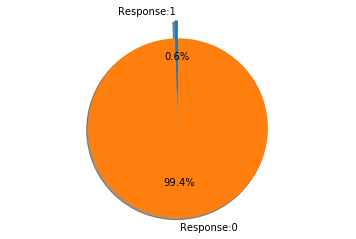

In [14]:
plt_pipe(counts_1_all_l[0].asDict())

In [14]:
counts_by_col = df_num2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_num2.columns])

In [ ]:
counts_by_col.limit(1).toPandas()

In [15]:
counts_by_col_l = counts_by_col.collect()

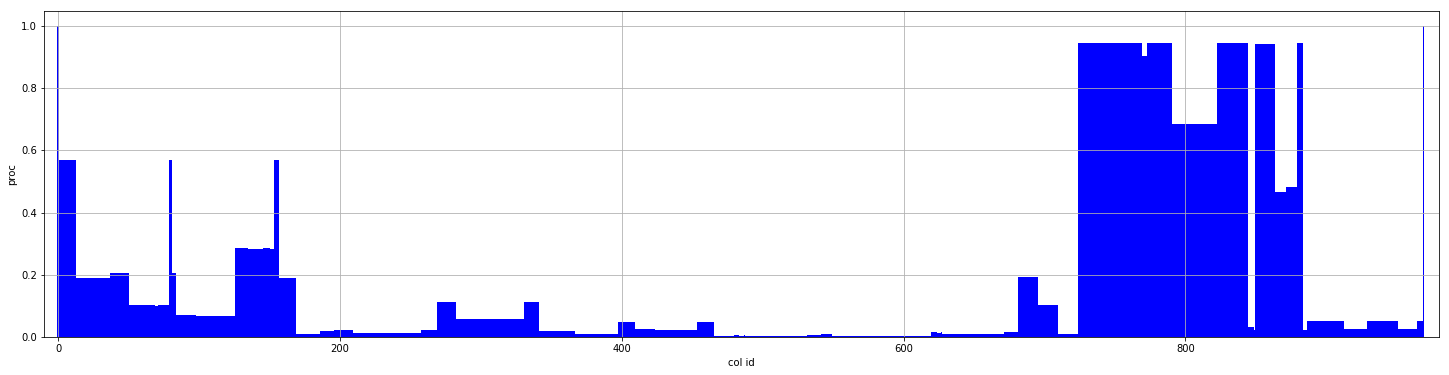

In [106]:
plt_hist(counts_by_col_l[0].asDict())

In [ ]:
col_with_resp = df_num2.filter(df_num2.Response == 1 ).select(*[(F.count(c) / F.count("*")).alias(c) for c in df_num2.columns])

In [ ]:
col_with_resp.limit(100).toPandas()

In [ ]:
col_with_resp_l = col_with_resp.collect()

In [ ]:
plt_hist(col_with_resp_l[0].asDict())

In [16]:
counts_by_col3 = df_date2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_date2.columns])

In [ ]:
counts_by_col3.limit(1).toPandas()

In [17]:
counts_by_col_l3 = counts_by_col3.collect()

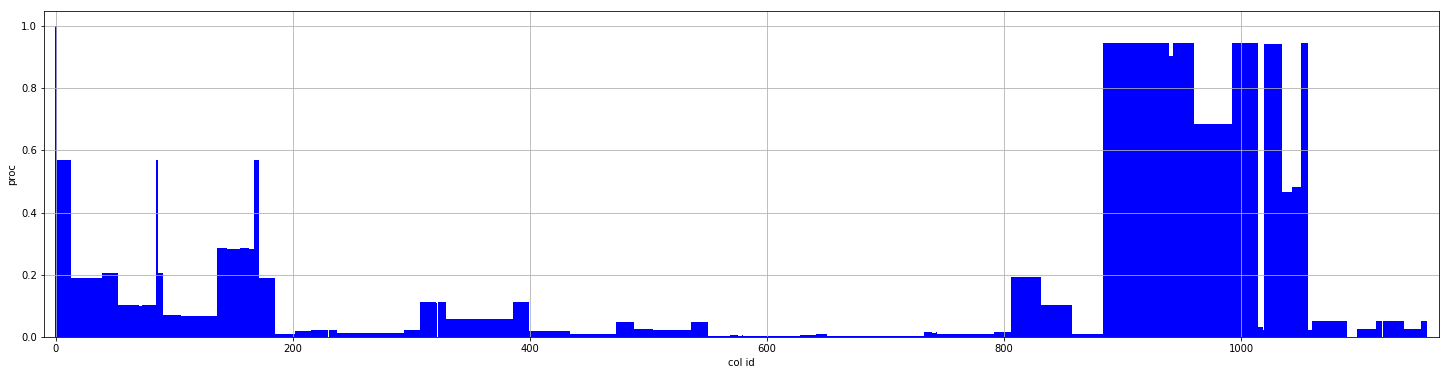

In [117]:
plt_hist(counts_by_col_l3[0].asDict())

In [18]:
counts_by_col4 = df_cat2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_cat2.columns])

In [19]:
counts_by_col_l4 = counts_by_col4.collect()

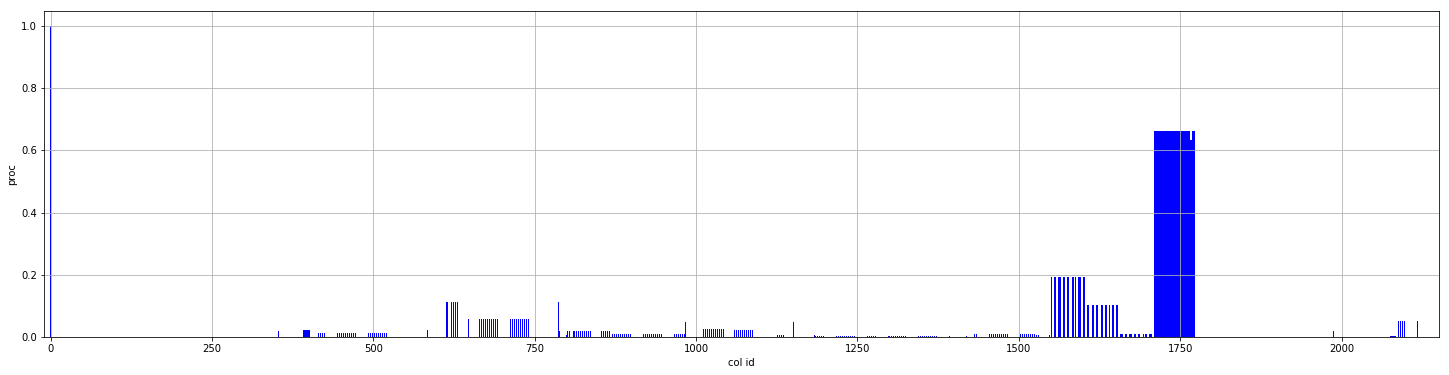

In [120]:
plt_hist(counts_by_col_l4[0].asDict())

In [19]:
# @jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf == 0:
        return 0
    else:
        return sup / np.sqrt(inf)


def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true)  # number of positive
    numn = n - nump  # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)

        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [23]:
df_date2 = df_date2.select("*",)

In [25]:
replace_cat_vals = F.udf(lambda val: 1 if val == 'T1' else 100, IntegerType())
flt_df_cat = flt_df_cat.select(flt_df_cat.Id, *[replace_cat_vals(c).alias(c) for c in flt_df_cat.columns if c != 'Id'])

In [28]:
full_df = flt_df_num.join(flt_df_date,flt_df_num.Id == flt_df_date.Id,'inner').drop(flt_df_date.Id)
full_df = full_df.join(flt_df_cat,full_df.Id == flt_df_cat.Id, 'inner').drop(flt_df_cat.Id)

In [29]:
full_df.write.csv('{0}/{1}'.format(dir_name,'full_df.csv'),sep=',',header=True,quote='')

In [31]:
full_df2 = sqlContext.read.csv('{0}/{1}'.format(dir_name,'full_df.csv'), sep=',', header=True, inferSchema=True)

### Creation of Models 

In [32]:
full_df3 = full_df2

In [20]:
from pyspark.ml.classification import GBTClassifier,RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,PCA

In [35]:
features = [c for c in full_df3.columns if c != 'Id' and c != 'Response']

In [36]:
vecAssembler = VectorAssembler(inputCols=features, outputCol="features")

In [37]:
%%time
ass = vecAssembler.transform(full_df3)

CPU times: user 44 ms, sys: 16 ms, total: 60 ms
Wall time: 1.04 s


In [38]:
assd = ass.select(['Id','Response','features']).drop()

In [39]:
assd.limit(5).toPandas()
#assd.printSchema()

Id  Response                                           features
0   616         0  [9999999.0, 9999999.0, 0.0, 9999999.0, 0.071, ...
1   632         0  [9999999.0, 9999999.0, 0.0, 9999999.0, -0.003,...
2   681         0  [9999999.0, 9999999.0, 9999999.0, 9999999.0, 9...
3  1392         0  [9999999.0, 9999999.0, 0.0, 9999999.0, -0.041,...
4  1526         0  [9999999.0, -0.06, 0.0, -0.048, 0.071, 0.0, 99...

In [89]:
selector = PCA(inputCol="features",outputCol="pca_features",k=150)
selectorModel = selector.fit(assd)

In [95]:
assd_pca = selectorModel.transform(assd)

In [96]:
assd_pca = assd_pca.select(assd_pca.Id,assd_pca.Response,assd_pca.pca_features.alias('features'))

In [97]:
assd_pca.limit(10).toPandas()

Id  Response                                           features
0   616         0  [-14800141.0267, -11850196.7376, -15041527.337...
1   632         0  [-60212203.2331, -1938971.22418, -62560141.312...
2   681         0  [-185774626.071, 34756944.3064, 6541367.92099,...
3  1392         0  [-14638198.0166, -11615436.458, -14983852.8253...
4  1526         0  [-55103249.0212, 1036295.53263, 41394941.224, ...
5  2063         0  [-54752882.5812, 1278373.30855, 41453234.3806,...
6  2423         0  [-88364506.52, 94931875.8661, -25848100.0669, ...
7  2621         0  [21750591.8206, 79928918.9989, 575880.453382, ...
8  3464         0  [21574524.0218, 79897548.2899, 617134.480183, ...
9  3554         0  [-60363752.6437, -1971104.02712, -62507128.792...

In [114]:
assd0 = assd_pca.filter(assd.Response == 0).sample(False, 0.006,43)

In [115]:
assd1 = assd_pca.filter(assd.Response == 1)

In [116]:
assd_n = assd0.union(assd1)

In [117]:
assd_pca.limit(10).toPandas()

Id  Response                                           features
0   616         0  [-14800141.0267, -11850196.7376, -15041527.337...
1   632         0  [-60212203.2331, -1938971.22418, -62560141.312...
2   681         0  [-185774626.071, 34756944.3064, 6541367.92099,...
3  1392         0  [-14638198.0166, -11615436.458, -14983852.8253...
4  1526         0  [-55103249.0212, 1036295.53263, 41394941.224, ...
5  2063         0  [-54752882.5812, 1278373.30855, 41453234.3806,...
6  2423         0  [-88364506.52, 94931875.8661, -25848100.0669, ...
7  2621         0  [21750591.8206, 79928918.9989, 575880.453382, ...
8  3464         0  [21574524.0218, 79897548.2899, 617134.480183, ...
9  3554         0  [-60363752.6437, -1971104.02712, -62507128.792...

In [118]:
tr_dt,tst_dt = assd_pca.randomSplit([0.7,0.3])

In [119]:
rfc = RandomForestClassifier(numTrees=50, maxDepth=5, labelCol="Response", seed=201)

In [125]:
tr_dt.show()

+----+--------+--------------------+
|  Id|Response|            features|
+----+--------+--------------------+
| 221|       0|[-4.2616456197303...|
| 662|       0|[-2484159.9136024...|
| 835|       0|[-4.2615926488981...|
|1222|       0|[-1.4813420789474...|
|1225|       0|[-4.2791575362666...|
|1237|       0|[-1.8386202558379...|
|1392|       0|[-1.4638198016554...|
|1895|       0|[-6.0360067469398...|
|2063|       0|[-5.4752882581227...|
|2131|       0|[-1.8562938191507...|
|2184|       0|[-1.4804746431321...|
|2421|       0|[2.17475455652968...|
|2423|       0|[-8.8364506519994...|
|2621|       0|[2.17505918205811...|
|2891|       0|[-4.2797199445829...|
|2984|       0|[-1.8564875119256...|
|2987|       0|[-5.4890358987665...|
|3082|       0|[-4.2793724474984...|
|3181|       0|[-5.4936057598429...|
|3345|       0|[-5.4953494453717...|
+----+--------+--------------------+
only showing top 20 rows



In [120]:
%%time
model = rfc.fit(tr_dt)

CPU times: user 120 ms, sys: 8 ms, total: 128 ms
Wall time: 17min 14s


In [60]:
l = [(k,v) for k,v in enumerate(fti)]
ls = sorted(l,key= lambda r:r[1],reverse=True)
ls

[(364, 0.080267763500573408),
 (262, 0.069949887230022031),
 (115, 0.053014215830289868),
 (52, 0.043871341695302407),
 (87, 0.041532406895582907),
 (319, 0.041247726876347292),
 (136, 0.040613562023527415),
 (191, 0.032540378309814093),
 (292, 0.030011212629576345),
 (65, 0.028618167872538562),
 (88, 0.027745305876811264),
 (211, 0.027658978549798312),
 (209, 0.025916674650908883),
 (46, 0.024709042362487145),
 (202, 0.024681375148027231),
 (95, 0.023800403087806121),
 (237, 0.021274106213524168),
 (98, 0.020735794875357795),
 (86, 0.019340084386997327),
 (239, 0.018645568324960279),
 (147, 0.018303068476105213),
 (199, 0.017624475104911955),
 (220, 0.015267234878887537),
 (201, 0.015129852220690052),
 (230, 0.01437355179496767),
 (7, 0.014180281607633615),
 (155, 0.014134699071071588),
 (58, 0.013470269195850095),
 (20, 0.013443302850563903),
 (29, 0.012851967770313071),
 (159, 0.012233768998858002),
 (157, 0.011843588951752537),
 (45, 0.011717003135869854),
 (268, 0.0114124740239315

In [121]:
pr = model.transform(tst_dt)

In [122]:
pr.show()

+----+--------+--------------------+--------------------+--------------------+----------+
|  Id|Response|            features|       rawPrediction|         probability|prediction|
+----+--------+--------------------+--------------------+--------------------+----------+
| 265|       0|[-5.5059986706710...|[49.8413286444144...|[0.99682657288828...|       0.0|
| 407|       0|[-4.8227132773116...|[49.7106245438695...|[0.99421249087739...|       0.0|
| 457|       0|[7196744.98570346...|[49.7202634067274...|[0.99440526813454...|       0.0|
| 616|       0|[-1.4800141026705...|[49.8415091399721...|[0.99683018279944...|       0.0|
| 632|       0|[-6.0212203233109...|[49.7191910609986...|[0.99438382121997...|       0.0|
| 681|       0|[-1.8577462607146...|[49.7520178860112...|[0.99504035772022...|       0.0|
|1526|       0|[-5.5103249021181...|[49.8344698395687...|[0.99668939679137...|       0.0|
|1603|       0|[-2658693.2143116...|[49.8262998895224...|[0.99652599779044...|       0.0|
|2460|    

In [123]:
label_pred_list = pr.select(pr['Response'],pr['prediction']).collect()

### Testing Models

### Results evaluation

In [109]:
def matthews_corr_coef(label_pred_list): 
    import math
    tp = np.sum(1 for r in label_pred_list if r[0] == 1 and r[1] == 1)
    tn = np.sum(1 for r in label_pred_list if r[0] == 0 and r[1] == 0)
    fp = np.sum(1 for r in label_pred_list if r[0] == 0 and r[1] == 1)
    fn = np.sum(1 for r in label_pred_list if r[0] == 1 and r[1] == 0)
    print "True Positives:", tp
    print "True Negatives:", tn
    print "False Positives:", fp
    print "False Negatives:", fn
    #print "Total", df.count()
    try:
        MCC = ((tp * tn) - (fp * fn)) / math.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
    except ZeroDivisionError:
        MCC = -1
    print "Matthews correlation coefficient: ", MCC

In [124]:
matthews_corr_coef(label_pred_list)

True Positives: 0
True Negatives: 353672
False Positives: 0
False Negatives: 2041
Matthews correlation coefficient:  -1
